In [2]:
%load_ext autoreload
%autoreload 2

# Comparing model-generated ruggedness and sequence-level ruggedness

In [3]:
import os
import pandas as pd
import jax
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from evoscaper.utils.evolution import calculate_ruggedness_core
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from bioreaction.misc.misc import load_json_as_dict


jax.config.update('jax_platform_name', 'cpu')

In [2]:
# Load dataset 1127
fn_1127 = os.path.join('..', 'data', 'raw', 'summarise_simulation', '2024_11_27_145142', 'tabulated_mutation_info.csv')
ds_1127 = pd.read_csv(fn_1127)
ds_1127.sort_values(by=['circuit_name', 'mutation_num', 'sample_name'], inplace=True)

# Load dataset 0211
# fn_0211 = os.path.join('data', 'simulate_circuits', '2025_02_11__13_56_51', 'tabulated_mutation_info.json')
# ds_0211 = pd.read_json(fn_0211)

# Load model for ruggedness


# Load previously verified ruggedness fake circuits


In [ ]:
n_species = ds_1127['sample_name'].dropna().nunique()
if 'Log sensitivity' not in ds_1127.columns:
    ds_1127['Log sensitivity'] = np.log10(ds_1127['sensitivity'])
    ds_1127['Log precision'] = np.log10(ds_1127['precision'])
if 'adaptation' not in ds_1127.columns:
    ds_1127['adaptation'] = calculate_adaptation(ds_1127['sensitivity'].values, ds_1127['precision'].values, alpha=2)
    
filt_spec = ds_1127['sample_name'] != 'RNA_0'
filt_e = ds_1127['sample_name'] == 'RNA_2'

# Ruggedness of sequence

In [65]:
def calc_diffs(data, columns):
    diffs = data.groupby(['circuit_name', 'sample_name']).apply(
        lambda x: x[x['mutation_name'] == 'ref_circuit'][columns].values
        - x[x['mutation_name'] != 'ref_circuit'][columns].values)
    return np.array(diffs.to_list())


def calc_ratio(x, columns):
    values_mut = x[x['mutation_name'] != 'ref_circuit'][columns].values
    values_ref = x[x['mutation_name'] == 'ref_circuit'][columns].values
    ratios = np.where(values_ref == 0, 1 + (values_mut - values_ref), 
                      values_mut / values_ref)
    return ratios


def calc_divs(data, columns):
    diffs = data.groupby(['circuit_name', 'sample_name']).apply(
        lambda x: calc_ratio(x, columns))
    return np.array(diffs.to_list())


def calc_ruggedness_seq(data, columns, mut_nums, n_species):
    divs = calc_divs(data, columns).reshape(n_species, -1, mut_nums.shape[-1])
    divs_norm_log = np.log10(divs) / np.power(np.repeat(mut_nums,
                        repeats=n_species).reshape(divs.shape), 2)
    rugg = np.sum(divs_norm_log, axis=-1)
    return rugg

In [ ]:
# Calculate approximate ruggedness score for all circuits based on difference to mutated circuits
# Weight the metric by the number of sequence mutations, eg: dm = d1m / 1 + d2m / 2 + d5m / 5

mut_nums = np.array(ds_1127[filt_e & (ds_1127['mutation_num'] > 0)].groupby(
    'circuit_name').apply(lambda x: x['mutation_num'].values).to_list())

cols_e = get_true_interaction_cols(
    ds_1127, 'energies', remove_symmetrical=True)
diffs_e = calc_diffs(ds_1127[filt_e], cols_e)
rugg_seq_e = np.sum(diffs_e / mut_nums[..., None], axis=-1)

# Plot seq-based rugg and param-based rugg on x y plot -> should be linear

# Plot intensity of energy changed vs. sequence change

# Run full model on ds 0211 + 1127 and compare latent spaces
# Do clusters of motifs

/tmp/ipykernel_1516015/1477818732.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'circuit_name').apply(lambda x: x['mutation_num'].values).to_list())
/tmp/ipykernel_1516015/1477818732.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  diffs = data.groupby(['circuit_name', 'sample_name']).apply(


/tmp/ipykernel_1516015/2880837084.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  diffs = data.groupby(['circuit_name', 'sample_name']).apply(
/tmp/ipykernel_1516015/2880837084.py:24: RuntimeWarning: invalid value encountered in log10
  divs_norm_log = np.log10(divs) / np.power(np.repeat(mut_nums,


Text(0.5, 0, 'Ruggedness (sequence)')

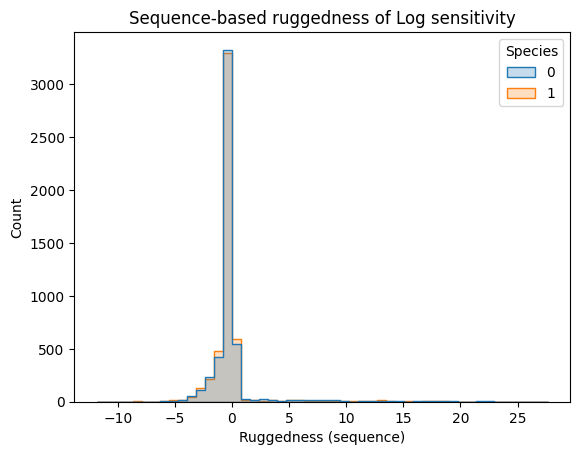

In [61]:
k = 'Log sensitivity'
rugg_seq_sens = calc_ruggedness_seq(ds_1127[filt_spec], k, mut_nums, n_species=n_species-1)

ax = sns.histplot(rugg_seq_sens.T.reshape(-1, n_species-1), bins=50, log_scale=[False, False], element='step')
# sns.histplot(x=np.log10(diffs_sens).flatten(), hue=np.repeat(mut_nums, repeats=3).flatten(), bins=50, log_scale=[False, False], element='step')
plt.title(f'Sequence-based ruggedness of {k}')
ax.get_legend().set_title('Species')
plt.xlabel('Ruggedness (sequence)')

/tmp/ipykernel_1516015/2880837084.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  diffs = data.groupby(['circuit_name', 'sample_name']).apply(


Text(0.5, 0, 'Ruggedness (sequence)')

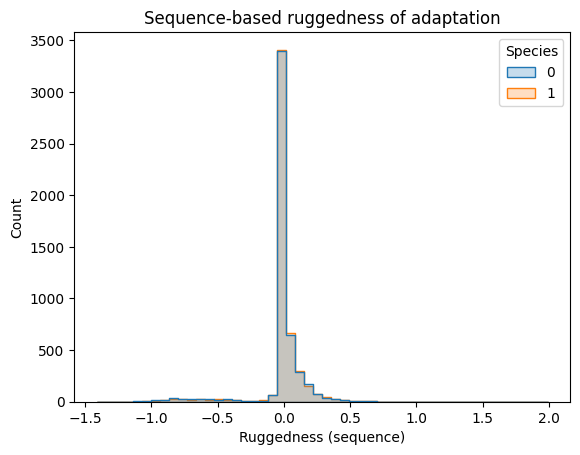

In [62]:
k = 'adaptation'
rugg_seq = calc_ruggedness_seq(ds_1127[filt_spec], k, mut_nums, n_species=n_species-1)


ax = sns.histplot(rugg_seq.T.reshape(-1, n_species-1), bins=50, log_scale=[False, False], element='step')
# sns.histplot(x=np.log10(diffs_sens).flatten(), hue=np.repeat(mut_nums, repeats=3).flatten(), bins=50, log_scale=[False, False], element='step')
plt.title(f'Sequence-based ruggedness of {k}')
ax.get_legend().set_title('Species')
plt.xlabel('Ruggedness (sequence)')

In [63]:
# ds_1127['Ruggedness (seq) energies'] = np.repeat(np.concatenate(
#     [rugg_seq_e, np.zeros(len(rugg_seq_e))[:, None]], axis=-1), repeats=3)
# ds_1127[f'Ruggedness (seq) {k}'] = np.concatenate(
#     [rugg_seq_sens, np.zeros(len(rugg_seq_sens))[:, None]], axis=-1)


# Ruggedness of topology

In [ ]:
dir_rugg_1127 = '/workdir/notebooks/data/ruggedness/2025_03_17__17_28_22'

config_run = load_json_as_dict(os.path.join(dir_rugg_1127, 'config.json'))

analytics_rugg = load_json_as_dict(os.path.join(dir_rugg_1127, 'analytics.json'))

# Stitch together ruggedness from batches
# analytics_rugg = {}
# # for fn_analytic in ['analytics.json', 'analytics2.json']:
# for dir_batch in [f'batch_{i}' for i in np.arange(12)]:
#     if (not os.path.exists(os.path.join(dir_rugg_1127, dir_batch))) or (
#         len(os.listdir(os.path.join(dir_rugg_1127, dir_batch))) == 0):
#         continue
#     analytics_batch = load_json_as_dict(os.path.join(dir_rugg_1127, dir_batch, 'analytics.json'))
#     # analytics_batch = load_json_as_dict(os.path.join(dir_rugg_1127, fn_analytic))
#     for k, v in analytics_batch.items():
#         if k not in analytics_rugg:
#             analytics_rugg[k] = np.array(v)
#         else:
#             analytics_rugg[k] = np.concatenate([analytics_rugg[k], np.array(v)], axis=0)
            
# if 'adaptation' not in analytics_rugg.keys():
#     analytics_rugg['adaptation'] = calculate_adaptation(analytics_rugg['sensitivity'], analytics_rugg['precision'], alpha=2)

# from synbio_morpher.utils.data.data_format_tools.common import write_json
# write_json(analytics_rugg, os.path.join(dir_rugg_1127, 'analytics.json'))

: 

In [ ]:
if 'adaptation' not in analytics_rugg.keys():
    analytics_rugg['adaptation'] = calculate_adaptation(analytics_rugg['sensitivity'], analytics_rugg['precision'], alpha=2)

# from synbio_morpher.utils.data.data_format_tools.common import write_json
# write_json(analytics_rugg, os.path.join(dir_rugg_1127, 'analytics.json'))

In [ ]:
k = 'adaptation'
config_run = load_json_as_dict(os.path.join(dir_rugg_1127, 'config.json'))
interactions = ds_1127[filt_e][cols_e].values
n_samples = len(interactions)
n_perturbs = len(cols_e)
eps = config_run['eps_perc'] * np.abs(interactions).max()
ruggedness = calculate_ruggedness_core(analytics_rugg, None, k,
                                        config_run, n_samples, n_perturbs, eps)

TypeError: cannot reshape array of shape (1414973, 9) (size 12734757) into shape (845000, 6, -1) because the product of specified axis sizes (5070000) does not evenly divide 12734757

In [ ]:
rugg = np.load('data/ruggedness/2025_03_17__17_28_22/batch_0/ruggedness.npy')

ds_1127_smol = ds_1127.iloc[:rugg.shape[0]]

ds_1127_smol['Ruggedness (energies) Log sensitivity'] = rugg


(142858, 9)

In [ ]:
import seaborn as sns
sns.histplot(ds_1127_smol, x='Ruggedness (energies) Log sensitivity', y='Ruggedness (seq) Log sensitivity', bins=100)